In [1]:
import os
import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import Tensor
from typing import Any, Callable, List, Optional, Tuple
from easydict import EasyDict

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Model

In [2]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.residual_function = nn.Sequential(
            # 3x3, 
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, \
                      padding=1, bias=False),
            # Batch Normalization
            nn.BatchNorm2d(out_channels),
            # ReLU
            nn.ReLU(),
            # 3x3
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, \
                      kernel_size=3, stride=1, padding=1, bias=False),
            # Batch Normalization
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )
        # basic shortcut = just add / if size change : projection shortcut
        self.shortcut = nn.Sequential()
        # after basic block, ReLU
        self.relu = nn.ReLU()
        
        # stride!=1 == size changes(downsampling) or channel size different
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                # make in channel, out channel matching
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, \
                          kernel_size=1, stride=stride, bias=False),
                # Batch Normalization
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

        def forward(self, x):
            x = self.residual_function(x) + self.shortcut(x)
            x = self.relu(x)
            return x

In [3]:
class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super(BottleNeck, self).__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, \
                      bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride,\
                      padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels*BottleNeck.expansion, \
                      kernel_size=1, stride=1, bias = False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion)
        )
        self.shortcut = nn.Sequential()
        self.relu = nn.ReLU()
        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BottleNeck.expansion,\
                          kernel_size = 1, stride = stride, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )
        
    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

In [4]:
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=10, init_weights=True):
        super(ResNet, self).__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        # input size : channel x kernel x kernel -> channel x 1 x 1
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        # channel -> num_classes
        # if basic block : 512 -> num_classes / bottleneck : 2048 -> num_classes
        self.fc = nn.Linear(512*block.expansion, num_classes)
        
        # if initialize weights(He initialization)
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        # since only first stride changes, ex. [2, 1, 1]
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            # example conv2_x, in_channels, out_channels : (64, 64)(proj?), (256, 64)..
            # example conv3_x, in_channels, out_channels : (128, 128)(proj), (512, 128)..
            layers.append(block(self.in_channels, out_channels, stride))
            # if bottleneck : 64,64,256 -> 256 -> 64,64,256 -> 256 -> ...
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers) 

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = nn.Flatten()(x) # same as x.view(x.size(0), -1)
        x = self.fc(x)

        return x

    # initialize weights
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    # if bias exist, bias = 0
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [5]:
def resnet18():
    return ResNet(BasicBlock, [2,2,2,2])

def resnet34():
    return ResNet(BasicBlock, [3,4,6,3])

def resnet50():
    return ResNet(BottleNeck, [3,4,6,3])

def resnet101():
    return ResNet(BottleNeck, [3,4,23,3])

def resnet152():
    return ResNet(BottleNeck, [3,8,36,3])

In [6]:
# test
model = resnet50()
x = torch.randn(3, 3, 224, 224)
print(model(x).size())

torch.Size([3, 10])


In [7]:
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
summary(model, (3,224,224), device = device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Train
Train model by CIFAR-10 datasets

In [8]:
def load_dataset():
    # preprocess
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        transforms.Resize((224, 224))
    ])

    # load data
    train = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True) 
    test = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)
    train_loader = DataLoader(train, batch_size=args.batch_size, shuffle = True)
    test_loader = DataLoader(test, batch_size=args.batch_size, shuffle=True)
    return train_loader, test_loader

# use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print("we use GPU")
else:
    print("we use CPU")

we use GPU


In [12]:
# hyperparameter
args = EasyDict()
args.batch_size = 100
args.learning_rate = 0.01
args.n_epochs = 10
args.weight_decay = 0.0001
args.momentum = 0.9

# functions
model = resnet50().to(device)
criterion = nn.CrossEntropyLoss(reduction = 'sum').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
# scheduler : on plateau with patience 10, reduce by 10 and print it is reduced
# in below train code, we don't use scheduler. See appendix to use scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer, mode = 'min', \
                                                       factor=0.1, patience = 10, verbose=True)
PATH = '/content/gdrive/MyDrive/Colab Notebooks/resnet.pt'
import os.path

epoch_start = 1

if os.path.exists(PATH):
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_start = checkpoint['epoch']
    print("successfully loaded!")
    print("epoch starts from here:", epoch_start)

successfully loaded!
epoch starts from here: 3


In [13]:
import time

# load dataset
train_loader, test_loader = load_dataset()

loss_hist = []
accuracy_hist = []

start_time = time.time()

print(f"we will start from:{epoch_start+1}")
# train
for epoch in range(epoch_start+1, args.n_epochs+1):
    model.train()
    train_loss = 0
    correct, count = 0, 0
    for batch_idx, (images, labels) in enumerate(train_loader, start=1):
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        optimizer.zero_grad()
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(output, 1) # torch max output is (max, max_index)
        count += labels.size(0)
        correct += torch.sum(preds == labels)
        
    loss_hist.append(train_loss/count)
    accuracy_hist.append(correct/count)
    print(f"[*] Epoch: {epoch} \tTrain accuracy: {correct/count} \tTrain Loss: {train_loss/count}")
    torch.save({
        'epoch' : epoch,
        'model_state_dict' : model.state_dict(),
        'optimizer_state_dict' : optimizer.state_dict(),
        }, PATH)

end_time = time.time()

print(f"Training time : {end_time - start_time}")

Files already downloaded and verified
Files already downloaded and verified
we will start from:4
[*] Epoch: 4 	Train accuracy: 0.7275599837303162 	Train Loss: 0.7708864000701904
[*] Epoch: 5 	Train accuracy: 0.7790399789810181 	Train Loss: 0.6341631507873535
[*] Epoch: 6 	Train accuracy: 0.8135600090026855 	Train Loss: 0.5347747239303589
[*] Epoch: 7 	Train accuracy: 0.840719997882843 	Train Loss: 0.4580178423309326
[*] Epoch: 8 	Train accuracy: 0.8665799498558044 	Train Loss: 0.3789066904449463
[*] Epoch: 9 	Train accuracy: 0.8926799893379211 	Train Loss: 0.3043674970054627
[*] Epoch: 10 	Train accuracy: 0.9113399982452393 	Train Loss: 0.24676807146072388
Training time : 4179.7316563129425


In [14]:
# test
model.eval()
correct, count = 0, 0
test_loss = 0

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader, start=1):
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = criterion(output, labels)
        test_loss += loss.item()
        _, preds = torch.max(output, 1)
        count += labels.size(0)
        correct += torch.sum(preds == labels)

print(f"Test accuracy: {correct/count} \tTest Loss: {test_loss/count}")

Test accuracy: 0.7896999716758728 	Test Loss: 0.683822583770752


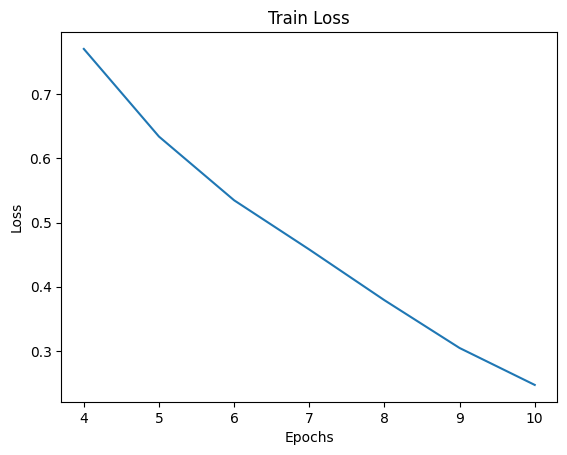

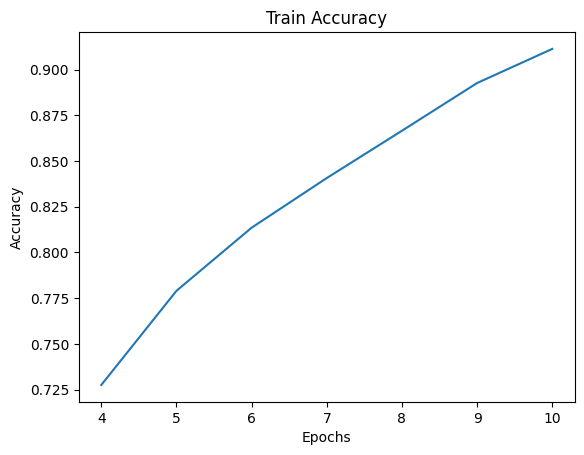

In [43]:
# plot graph
width = len(loss_hist)
plt.title("Train Loss")
plt.plot(range(epoch_start+1, width+epoch_start+1), loss_hist)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

accuracy_hist2 = torch.stack(accuracy_hist).cpu().tolist()
plt.title("Train Accuracy")
plt.plot(range(epoch_start+1, width+epoch_start+1), accuracy_hist2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [31]:
# why we should change accuracy_hist to

accuracy_hist2 = torch.stack(accuracy_hist)
accuracy_hist2.cpu().tolist()

[0.7275599837303162,
 0.7790399789810181,
 0.8135600090026855,
 0.840719997882843,
 0.8665799498558044,
 0.8926799893379211,
 0.9113399982452393]

In [41]:
accuracy_hist

[tensor(0.7276, device='cuda:0'),
 tensor(0.7790, device='cuda:0'),
 tensor(0.8136, device='cuda:0'),
 tensor(0.8407, device='cuda:0'),
 tensor(0.8666, device='cuda:0'),
 tensor(0.8927, device='cuda:0'),
 tensor(0.9113, device='cuda:0')]

## Appendix : ReduceLrOnPlateau

For ReduceLrOnPlateau, we have to make v
alidation-dataloader
we have to change two things


```
def load_dataset():
    # preprocess
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        transforms.Resize((224, 224))
    ])

    # load data
    train = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
    train_size = int(len(train) * 0.8) # 80% training data
    valid_size = len(train) - train_size # 20% validation data
    train, valid = random_split(train, [train_size, valid_size])
    
    test = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)
    train_loader = DataLoader(train, batch_size=args.batch_size, shuffle = True)
    val_loader = DataLoader(valid, batch_size=args.batch_size, shuffle=True)
    test_loader = DataLoader(test, batch_size=args.batch_size, shuffle=True)
    return train_loader, val_loader, test_loader
```
And then we have to make loss function for validation.
```
def loss_val(model, val_loader):
    total_loss = 0
    for batch_idx, (images, labels) in enumerate(val_loader, start=1):
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        total_loss += criterion(output, labels)
    loss = total_loss / len(val_loader)
    return loss
```
Finally we add this code on train code.
```
for epoch in range(args.n_epochs):
    model.train()
    train_loss = 0
    correct, count = 0, 0
    for batch_idx, (images, labels) in enumerate(train_loader, start=1):
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        optimizer.zero_grad()
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(output, 1) # torch max output is (max, max_index)
        count += labels.size(0)
        correct += torch.sum(preds == labels)
    # here!
    with torch.no_grad():
        val_loss = loss_val(model, val_loader)
    scheduler.step(val_loss)
```
Then scheduler will update learning rate by validation loss.